# GRPO Evaluation & Comparison Framework

A clean, unified notebook for evaluating GRPO checkpoints with three modes:
- **SINGLE_CHECKPOINT**: Evaluate one model against baselines
- **COMPARE_CHECKPOINTS**: Compare multiple checkpoints
- **COMPARE_OBJECTIVES**: Compare structure-focused vs target-focused models

## Features:
✅ Clean, linear execution flow
✅ No duplicate cells or logic
✅ Adaptive visualization for all modes
✅ Consistent data handling throughout
✅ Clear section dependencies

## 1. Environment Setup

In [1]:
#!/usr/bin/env python3
"""
Complete Environment Setup - All imports and configurations
"""

# Standard library
import sys
import os
import json
import glob
import subprocess
import time
import shutil
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Any, Optional, Tuple
from dataclasses import dataclass, field

# Configure paths
project_root = Path.cwd().parent if Path.cwd().name == "experiments" else Path.cwd()
sys.path.insert(0, str(project_root))

# Scientific computing
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as random
import pyrsistent as pyr

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Project imports
from causal_bayes_opt.experiments.variable_scm_factory import VariableSCMFactory
from causal_bayes_opt.acquisition.grpo_enriched_integration import EnrichedPolicyWrapper
from causal_bayes_opt.data_structures.scm import get_variables, get_target, get_edges

# Configure JAX
jax.config.update("jax_enable_x64", True)

# Configure logging
import logging
logging.basicConfig(
    level=logging.INFO,
    format='[%(asctime)s][%(name)s][%(levelname)s] - %(message)s'
)
logger = logging.getLogger(__name__)

print("✅ Environment Setup Complete")
print(f"📁 Project root: {project_root}")
print(f"🔧 JAX devices: {jax.devices()}")
print(f"📅 Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")

✅ Environment Setup Complete
📁 Project root: /Users/harellidar/Documents/Imperial/Individual_Project/causal_bayes_opt
🔧 JAX devices: [CpuDevice(id=0)]
📅 Date: 2025-07-22 16:08


In [2]:
"""
Data Classes and Helper Functions
"""

@dataclass
class CheckpointInfo:
    """Information about a checkpoint"""
    name: str
    path: Path
    metadata: Optional[Dict[str, Any]] = None
    objective: Optional[str] = None  # 'structure_focused', 'target_focused', etc.
    
    def __post_init__(self):
        # Extract objective from name or metadata
        if self.objective is None:
            if 'structure_focused' in self.name.lower():
                self.objective = 'structure_focused'
            elif 'target_focused' in self.name.lower():
                self.objective = 'target_focused'
            elif self.metadata and 'training_config' in self.metadata:
                # Handle uppercase objectives by converting to lowercase
                self.objective = self.metadata['training_config'].get('objective', 'unknown').lower()
            else:
                self.objective = 'unknown'

@dataclass
class TestParams:
    """Test configuration parameters"""
    num_test_scms: int = 10
    runs_per_method: int = 3
    intervention_budget: int = 10
    scm_variable_range: Tuple[int, int] = (3, 6)
    structure_types: List[str] = field(default_factory=lambda: ['fork', 'chain', 'collider', 'mixed'])

@dataclass
class EvaluationConfig:
    """Complete evaluation configuration"""
    mode: str  # "SINGLE_CHECKPOINT", "COMPARE_CHECKPOINTS", "COMPARE_OBJECTIVES"
    checkpoints: List[CheckpointInfo]
    test_params: TestParams
    output_dir: Path
    random_seed: int = 42
    
    def __post_init__(self):
        # Validate configuration
        valid_modes = ["SINGLE_CHECKPOINT", "COMPARE_CHECKPOINTS", "COMPARE_OBJECTIVES"]
        if self.mode not in valid_modes:
            raise ValueError(f"Invalid mode: {self.mode}. Must be one of {valid_modes}")
        
        if self.mode == "SINGLE_CHECKPOINT" and len(self.checkpoints) != 1:
            raise ValueError(f"SINGLE_CHECKPOINT mode requires exactly 1 checkpoint, got {len(self.checkpoints)}")
        
        if self.mode == "COMPARE_OBJECTIVES":
            objectives = [ckpt.objective for ckpt in self.checkpoints]
            if 'structure_focused' not in objectives or 'target_focused' not in objectives:
                logger.warning("COMPARE_OBJECTIVES mode expects both structure and target focused checkpoints")

@dataclass
class EvaluationResults:
    """Results from evaluation"""
    config: EvaluationConfig
    method_performance: Dict[str, Dict[str, float]]
    trajectory_data: Dict[str, Any]
    plots_generated: List[Path]
    duration_minutes: float
    success: bool = True
    
def discover_checkpoints(checkpoint_dirs: List[Path]) -> List[CheckpointInfo]:
    """Discover all available checkpoints"""
    checkpoints = []
    
    for checkpoint_dir in checkpoint_dirs:
        if not checkpoint_dir.exists():
            continue
            
        for item in checkpoint_dir.iterdir():
            if item.is_dir() and any(item.glob("*.pkl")):
                # Load metadata if available
                metadata = None
                
                # Check for metadata in multiple locations
                metadata_path = item.parent / f"{item.name}_metadata.json"
                if metadata_path.exists():
                    with open(metadata_path, 'r') as f:
                        metadata = json.load(f)
                else:
                    # Also check inside the checkpoint directory
                    metadata_path = item / "metadata.json"
                    if metadata_path.exists():
                        with open(metadata_path, 'r') as f:
                            metadata = json.load(f)
                
                checkpoint = CheckpointInfo(
                    name=item.name,
                    path=item,
                    metadata=metadata
                )
                checkpoints.append(checkpoint)
    
    return checkpoints

print("✅ Helper functions defined")

✅ Helper functions defined


In [3]:
"""
Configuration Cell - Select Evaluation Mode
"""

# Select evaluation mode
EVALUATION_MODE = "COMPARE_OBJECTIVES"  # Options: "SINGLE_CHECKPOINT", "COMPARE_CHECKPOINTS", "COMPARE_OBJECTIVES"

# Test parameters  
test_params = TestParams(
    num_test_scms=10,
    runs_per_method=3,
    intervention_budget=10,
    scm_variable_range=(3, 6)
)

# Random seed
RANDOM_SEED = 42

print(f"✅ Configuration set: {EVALUATION_MODE} mode")

✅ Configuration set: COMPARE_OBJECTIVES mode


## 3. Checkpoint Discovery and Selection

In [4]:
"""
Discover and Select Checkpoints Based on Mode
"""

print("🔍 Discovering Checkpoints")
print("=" * 60)

# Checkpoint directories to search
checkpoint_dirs = [
    project_root / "checkpoints" / "grpo_training",
    project_root / "checkpoints" / "grpo_testing",
    project_root / "checkpoints"
]

# Discover all checkpoints
all_checkpoints = discover_checkpoints(checkpoint_dirs)
print(f"Found {len(all_checkpoints)} total checkpoints")

# Group by objective
checkpoints_by_objective = {}
for ckpt in all_checkpoints:
    obj = ckpt.objective
    if obj not in checkpoints_by_objective:
        checkpoints_by_objective[obj] = []
    checkpoints_by_objective[obj].append(ckpt)

print("\nCheckpoints by objective:")
for obj, ckpts in checkpoints_by_objective.items():
    print(f"  {obj}: {len(ckpts)} checkpoints")

# Select checkpoints based on mode
selected_checkpoints = []

if EVALUATION_MODE == "SINGLE_CHECKPOINT":
    # Select most recent checkpoint (or modify index to select different one)
    if all_checkpoints:
        # Sort by modification time and take most recent
        all_checkpoints.sort(key=lambda x: x.path.stat().st_mtime, reverse=True)
        selected_checkpoints = [all_checkpoints[0]]
        print(f"\n✅ Selected checkpoint: {selected_checkpoints[0].name}")
    else:
        raise ValueError("No checkpoints found!")
        
elif EVALUATION_MODE == "COMPARE_CHECKPOINTS":
    # Select multiple checkpoints for comparison
    # By default, take the 3 most recent checkpoints
    if len(all_checkpoints) >= 2:
        all_checkpoints.sort(key=lambda x: x.path.stat().st_mtime, reverse=True)
        selected_checkpoints = all_checkpoints[:3]  # Modify number as needed
        print(f"\n✅ Selected {len(selected_checkpoints)} checkpoints for comparison:")
        for ckpt in selected_checkpoints:
            print(f"  - {ckpt.name}")
    else:
        raise ValueError(f"Need at least 2 checkpoints for comparison, found {len(all_checkpoints)}")
        
elif EVALUATION_MODE == "COMPARE_OBJECTIVES":
    # Select best checkpoint from each objective type
    for obj in ['structure_focused', 'target_focused']:
        if obj in checkpoints_by_objective:
            # Take most recent checkpoint for this objective
            obj_checkpoints = checkpoints_by_objective[obj]
            obj_checkpoints.sort(key=lambda x: x.path.stat().st_mtime, reverse=True)
            selected_checkpoints.append(obj_checkpoints[0])
    
    if len(selected_checkpoints) < 2:
        print("⚠️ Could not find both objective types, falling back to general comparison")
        # Fall back to comparing any two checkpoints
        if len(all_checkpoints) >= 2:
            all_checkpoints.sort(key=lambda x: x.path.stat().st_mtime, reverse=True)
            selected_checkpoints = all_checkpoints[:2]
    
    print(f"\n✅ Selected checkpoints for objective comparison:")
    for ckpt in selected_checkpoints:
        print(f"  - {ckpt.objective}: {ckpt.name}")

# Verify selection
if not selected_checkpoints:
    raise ValueError("No checkpoints selected!")

print(f"\n📊 Final selection: {len(selected_checkpoints)} checkpoint(s)")

🔍 Discovering Checkpoints
Found 10 total checkpoints

Checkpoints by objective:
  structure_focused: 1 checkpoints
  target_focused: 1 checkpoints
  unknown: 8 checkpoints

✅ Selected checkpoints for objective comparison:
  - structure_focused: grpo_quick_structure_focused_20250722_135335
  - target_focused: grpo_quick_target_focused_20250721_234828

📊 Final selection: 2 checkpoint(s)


## 4. Generate Test SCMs

In [5]:
"""
Generate Test SCMs for Evaluation
"""

print("🔬 Generating Test SCMs")
print("=" * 60)

# Create SCM factory
scm_factory = VariableSCMFactory(
    noise_scale=1.0,
    coefficient_range=(-2.0, 2.0),
    seed=RANDOM_SEED
)

# Generate balanced test set
test_scms = []
test_metadata = []
key = random.PRNGKey(RANDOM_SEED + 1000)  # Different seed for test set

# Calculate distribution
n_structure_types = len(test_params.structure_types)
n_var_sizes = test_params.scm_variable_range[1] - test_params.scm_variable_range[0] + 1
scms_per_config = test_params.num_test_scms // (n_structure_types * n_var_sizes)
remaining = test_params.num_test_scms % (n_structure_types * n_var_sizes)

# Generate SCMs
for structure_type in test_params.structure_types:
    for n_vars in range(test_params.scm_variable_range[0], test_params.scm_variable_range[1] + 1):
        n_instances = scms_per_config + (1 if remaining > 0 else 0)
        remaining = max(0, remaining - 1)
        
        for instance in range(n_instances):
            if len(test_scms) >= test_params.num_test_scms:
                break
                
            key, subkey = random.split(key)
            
            scm = scm_factory.create_variable_scm(
                num_variables=n_vars,
                structure_type=structure_type,
                target_variable=None,
                edge_density=0.5
            )
            
            test_scms.append(scm)
            test_metadata.append({
                'structure_type': structure_type,
                'n_variables': n_vars,
                'target': get_target(scm),
                'n_edges': len(get_edges(scm)),
                'variables': list(get_variables(scm))
            })

print(f"✅ Generated {len(test_scms)} test SCMs")

# Analyze distribution
structure_counts = {}
variable_counts = {}

for meta in test_metadata:
    struct = meta['structure_type']
    n_vars = meta['n_variables']
    structure_counts[struct] = structure_counts.get(struct, 0) + 1
    variable_counts[n_vars] = variable_counts.get(n_vars, 0) + 1

print("\n📊 Test Set Distribution:")
print(f"  Structure types: {structure_counts}")
print(f"  Variable counts: {variable_counts}")

[2025-07-22 16:08:50,256][causal_bayes_opt.experiments.test_scms][INFO] - Created linear SCM with 3 variables, 2 edges, target='X1'
[2025-07-22 16:08:50,256][causal_bayes_opt.experiments.variable_scm_factory][INFO] - Generated fork SCM: 3 vars, 2 edges, target=X1
[2025-07-22 16:08:50,270][causal_bayes_opt.experiments.test_scms][INFO] - Created linear SCM with 4 variables, 3 edges, target='X2'
[2025-07-22 16:08:50,270][causal_bayes_opt.experiments.variable_scm_factory][INFO] - Generated fork SCM: 4 vars, 3 edges, target=X2


🔬 Generating Test SCMs


[2025-07-22 16:08:50,284][causal_bayes_opt.experiments.test_scms][INFO] - Created linear SCM with 5 variables, 4 edges, target='X2'
[2025-07-22 16:08:50,285][causal_bayes_opt.experiments.variable_scm_factory][INFO] - Generated fork SCM: 5 vars, 4 edges, target=X2
[2025-07-22 16:08:50,299][causal_bayes_opt.experiments.test_scms][INFO] - Created linear SCM with 6 variables, 5 edges, target='X3'
[2025-07-22 16:08:50,299][causal_bayes_opt.experiments.variable_scm_factory][INFO] - Generated fork SCM: 6 vars, 5 edges, target=X3
[2025-07-22 16:08:50,314][causal_bayes_opt.experiments.test_scms][INFO] - Created linear SCM with 3 variables, 2 edges, target='X2'
[2025-07-22 16:08:50,314][causal_bayes_opt.experiments.variable_scm_factory][INFO] - Generated chain SCM: 3 vars, 2 edges, target=X2
[2025-07-22 16:08:50,316][causal_bayes_opt.experiments.test_scms][INFO] - Created linear SCM with 4 variables, 3 edges, target='X3'
[2025-07-22 16:08:50,316][causal_bayes_opt.experiments.variable_scm_factory

✅ Generated 10 test SCMs

📊 Test Set Distribution:
  Structure types: {'fork': 4, 'chain': 4, 'collider': 2}
  Variable counts: {3: 3, 4: 3, 5: 2, 6: 2}


## 5. Run Evaluation

In [6]:
"""
Run Evaluation Based on Selected Mode
"""

def run_single_checkpoint_evaluation(checkpoint: CheckpointInfo, test_scms: List, test_params: TestParams, output_dir: Path) -> Dict[str, Any]:
    """Run evaluation for a single checkpoint"""
    print(f"\n🚀 Evaluating checkpoint: {checkpoint.name}")
    
    # Use unified pipeline for consistent evaluation
    cmd = [
        "poetry", "run", "python",
        str(project_root / "scripts" / "unified_pipeline.py"),
        f"--checkpoint={checkpoint.path}",
        f"--num-scms={len(test_scms[:3])}",  # Use subset for speed
        f"--runs-per-method={test_params.runs_per_method}",
        f"--intervention-budget={test_params.intervention_budget}",
        f"--output-dir={output_dir}"
    ]
    
    print(f"Running: {' '.join(cmd[-5:])}...")
    start_time = time.time()
    
    result = subprocess.run(cmd, capture_output=True, text=True)
    
    if result.returncode == 0:
        duration = (time.time() - start_time) / 60
        print(f"✅ Completed in {duration:.1f} minutes")
        
        # Load results
        results_file = output_dir / "comparison_results.json"
        if not results_file.exists():
            # Search for results in common locations
            possible_locations = [
                *glob.glob(str(project_root / "results" / "acbo_comparison_*.json")),
                *glob.glob(str(project_root / "scripts" / "core" / "results" / "acbo_comparison_*.json"))
            ]
            
            if possible_locations:
                latest_file = max(possible_locations, key=lambda p: Path(p).stat().st_mtime)
                if Path(latest_file).stat().st_mtime >= start_time:
                    output_dir.mkdir(parents=True, exist_ok=True)
                    shutil.copy(latest_file, results_file)
        
        if results_file.exists():
            with open(results_file, 'r') as f:
                return json.load(f)
    
    print(f"❌ Evaluation failed: {result.stderr[:200]}...")
    return None

print("🏁 Starting Evaluation")
print("=" * 60)

# Create output directory
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
base_output_dir = project_root / "results" / f"evaluation_{EVALUATION_MODE.lower()}_{timestamp}"
base_output_dir.mkdir(parents=True, exist_ok=True)

# Store all results
all_results = {}
evaluation_start_time = time.time()

# Run evaluation based on mode
if EVALUATION_MODE == "SINGLE_CHECKPOINT":
    checkpoint = selected_checkpoints[0]
    output_dir = base_output_dir / checkpoint.name
    
    results = run_single_checkpoint_evaluation(checkpoint, test_scms, test_params, output_dir)
    if results:
        all_results[checkpoint.name] = results
        
elif EVALUATION_MODE in ["COMPARE_CHECKPOINTS", "COMPARE_OBJECTIVES"]:
    for i, checkpoint in enumerate(selected_checkpoints):
        output_dir = base_output_dir / checkpoint.name
        
        results = run_single_checkpoint_evaluation(checkpoint, test_scms, test_params, output_dir)
        if results:
            all_results[checkpoint.name] = results
        
        # Add checkpoint metadata to results
        if checkpoint.name in all_results:
            all_results[checkpoint.name]['checkpoint_info'] = {
                'name': checkpoint.name,
                'objective': checkpoint.objective,
                'path': str(checkpoint.path)
            }

total_duration = (time.time() - evaluation_start_time) / 60

# Create evaluation config and results
eval_config = EvaluationConfig(
    mode=EVALUATION_MODE,
    checkpoints=selected_checkpoints,
    test_params=test_params,
    output_dir=base_output_dir,
    random_seed=RANDOM_SEED
)

# Extract method performance and trajectory data
method_performance = {}
trajectory_data = {}

for checkpoint_name, results in all_results.items():
    if 'statistical_analysis' in results and 'summary_statistics' in results['statistical_analysis']:
        for method, stats in results['statistical_analysis']['summary_statistics'].items():
            key = f"{checkpoint_name}_{method}"
            method_performance[key] = {
                'checkpoint': checkpoint_name,
                'method': method,
                'target_improvement': stats.get('target_improvement_mean', 0.0),
                'structure_accuracy': stats.get('structure_accuracy_mean', 0.0),
                'runs': stats.get('target_improvement_count', 0)
            }
    
    if 'trajectory_data' in results:
        trajectory_data.update(results['trajectory_data'])

eval_results = EvaluationResults(
    config=eval_config,
    method_performance=method_performance,
    trajectory_data=trajectory_data,
    plots_generated=[],
    duration_minutes=total_duration,
    success=len(all_results) > 0
)

print(f"\n✅ Evaluation Complete!")
print(f"  Duration: {total_duration:.1f} minutes")
print(f"  Successful evaluations: {len(all_results)}/{len(selected_checkpoints)}")
print(f"  Output directory: {base_output_dir}")

🏁 Starting Evaluation

🚀 Evaluating checkpoint: grpo_quick_structure_focused_20250722_135335
Running: --checkpoint=/Users/harellidar/Documents/Imperial/Individual_Project/causal_bayes_opt/checkpoints/grpo_training/grpo_quick_structure_focused_20250722_135335 --num-scms=3 --runs-per-method=3 --intervention-budget=10 --output-dir=/Users/harellidar/Documents/Imperial/Individual_Project/causal_bayes_opt/results/evaluation_compare_objectives_20250722_160850/grpo_quick_structure_focused_20250722_135335...
✅ Completed in 7.9 minutes

🚀 Evaluating checkpoint: grpo_quick_target_focused_20250721_234828
Running: --checkpoint=/Users/harellidar/Documents/Imperial/Individual_Project/causal_bayes_opt/checkpoints/grpo_training/grpo_quick_target_focused_20250721_234828 --num-scms=3 --runs-per-method=3 --intervention-budget=10 --output-dir=/Users/harellidar/Documents/Imperial/Individual_Project/causal_bayes_opt/results/evaluation_compare_objectives_20250722_160850/grpo_quick_target_focused_20250721_2348

## 6. Results Visualization

📊 Generating Visualizations
✓ Plotting utilities imported successfully


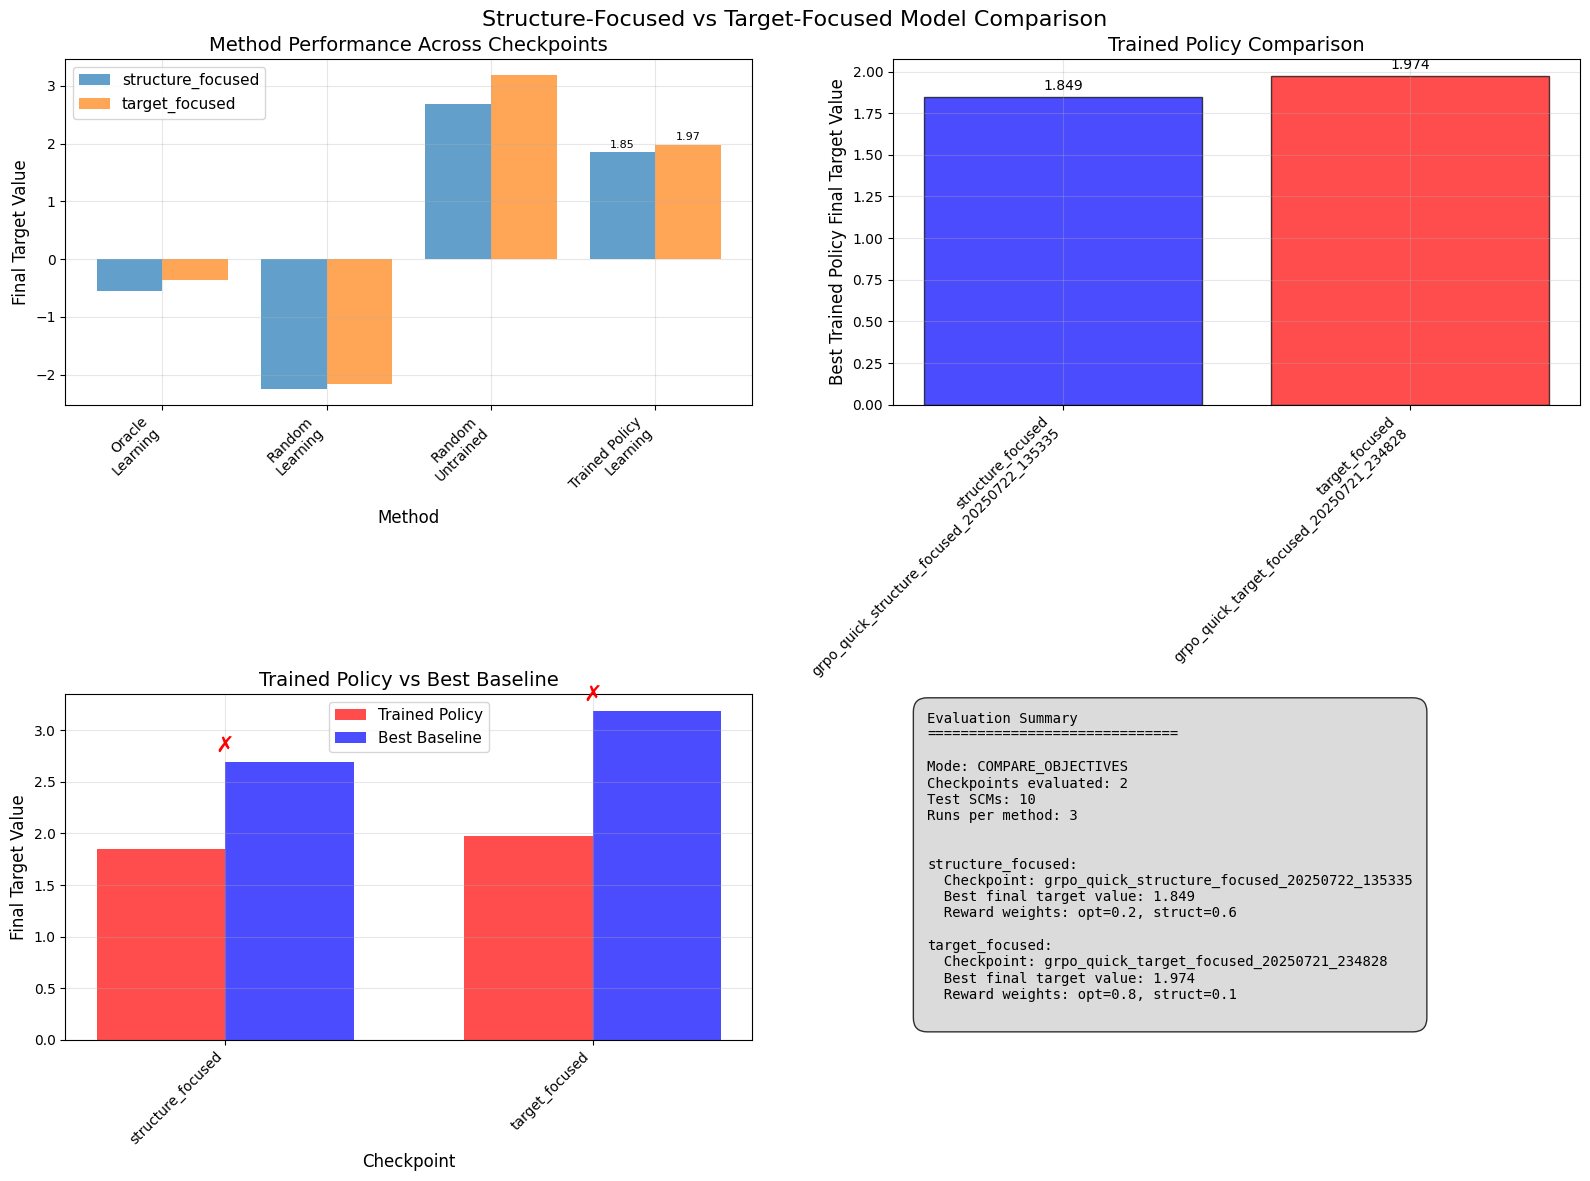


📈 Attempting to generate trajectory plots...
  all_results has 2 checkpoints
  trajectory_data has 96 entries

  Checkpoint: grpo_quick_structure_focused_20250722_135335
    Keys: ['experiment_config', 'method_results', 'statistical_analysis', 'visualizations', 'scm_summary', 'execution_metadata', 'aggregated_trajectories', 'trajectory_data', 'checkpoint_info']
    Has trajectory_data: True
    Trajectory entries: 96

  Checkpoint: grpo_quick_target_focused_20250721_234828
    Keys: ['experiment_config', 'method_results', 'statistical_analysis', 'visualizations', 'scm_summary', 'execution_metadata', 'aggregated_trajectories', 'trajectory_data', 'checkpoint_info']
    Has trajectory_data: True
    Trajectory entries: 96

  Processing grpo_quick_structure_focused_20250722_135335...
    ✓ Has both trajectory_data and aggregated_trajectories
    ✓ Plot data prepared: 4 methods


[2025-07-22 16:24:50,371][src.causal_bayes_opt.visualization.plots][INFO] - Saved baseline comparison plot to /Users/harellidar/Documents/Imperial/Individual_Project/causal_bayes_opt/results/evaluation_compare_objectives_20250722_160850/trajectory_grpo_quick_structure_focused_20250722_135335.png


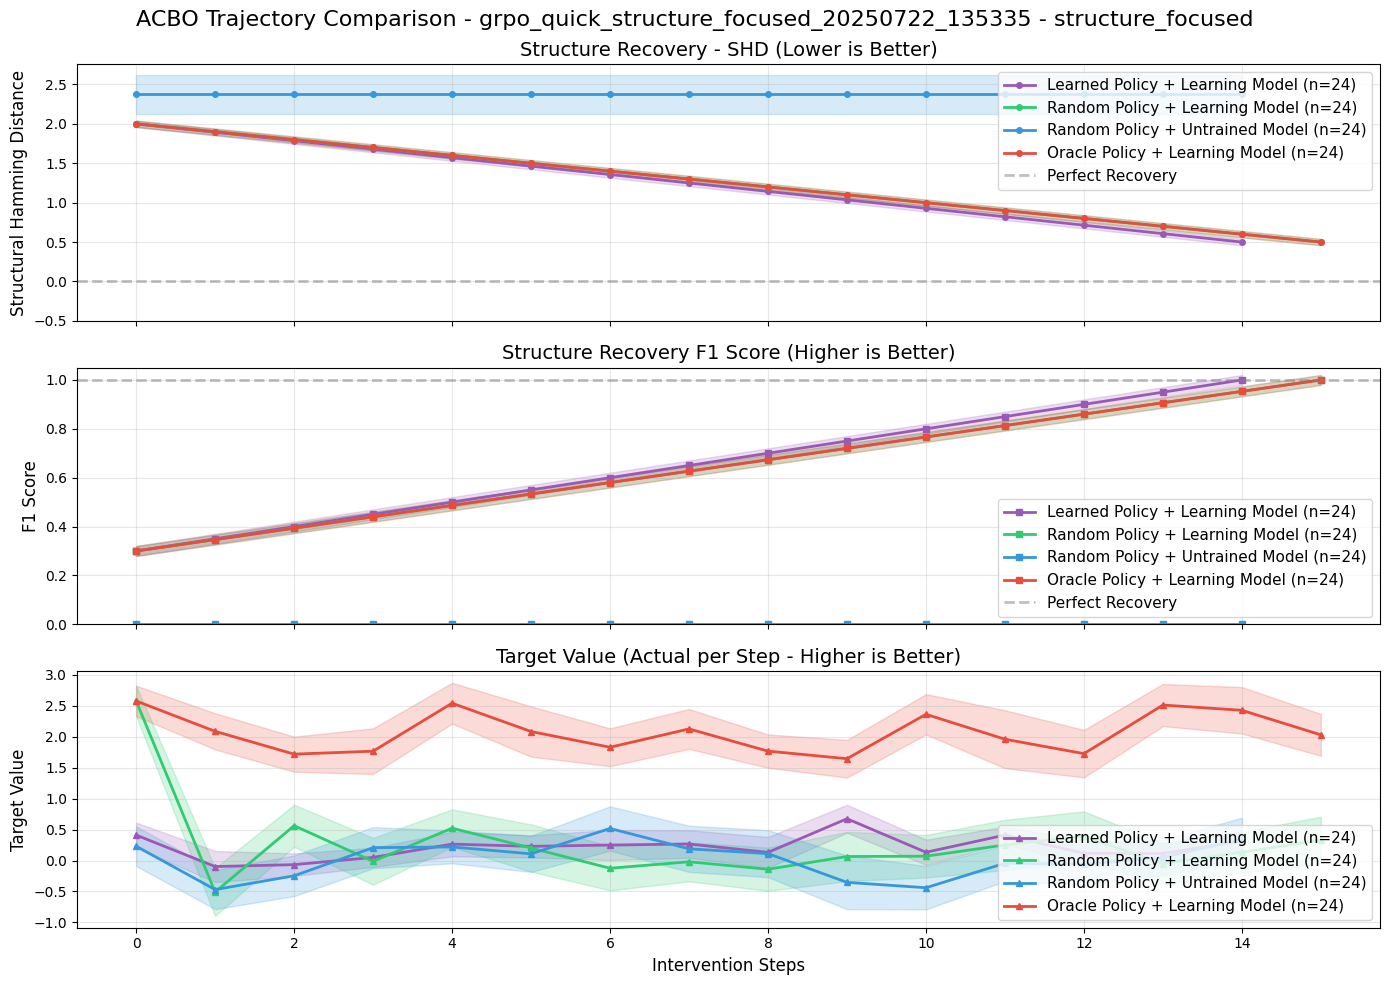

    ✓ Saved trajectory plot: trajectory_grpo_quick_structure_focused_20250722_135335.png

  Processing grpo_quick_target_focused_20250721_234828...
    ✓ Has both trajectory_data and aggregated_trajectories
    ✓ Plot data prepared: 4 methods


[2025-07-22 16:24:50,996][src.causal_bayes_opt.visualization.plots][INFO] - Saved baseline comparison plot to /Users/harellidar/Documents/Imperial/Individual_Project/causal_bayes_opt/results/evaluation_compare_objectives_20250722_160850/trajectory_grpo_quick_target_focused_20250721_234828.png


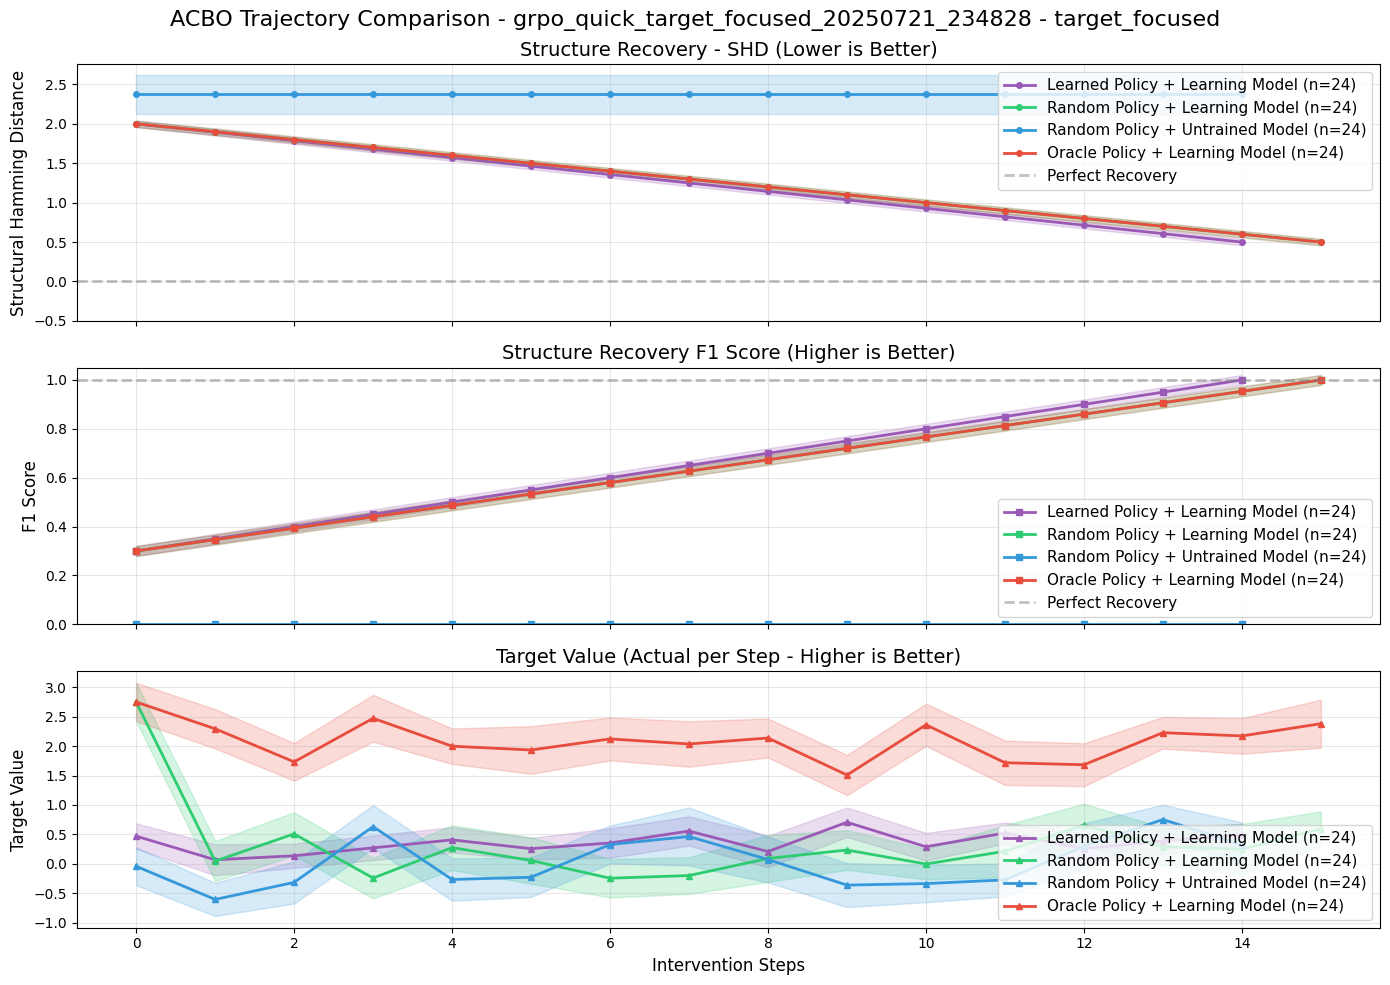

    ✓ Saved trajectory plot: trajectory_grpo_quick_target_focused_20250721_234828.png

✅ Generated 3 plots total
📁 Saved to: /Users/harellidar/Documents/Imperial/Individual_Project/causal_bayes_opt/results/evaluation_compare_objectives_20250722_160850

📊 Plot Guide:
  - Trajectory plots show performance over intervention steps:
    • Top panel: SHD (Structural Hamming Distance) - Lower is better
    • Middle panel: F1 Score - Higher is better
    • Bottom panel: Target Value (Actual per Step) - Higher is better
  - Summary plots show final target values for easy comparison

Note: Target trajectories now show actual values at each step (not cumulative best).
This allows you to see exploration behavior and variance in each method.


In [7]:
"""
Adaptive Visualization Based on Evaluation Mode
"""

print("📊 Generating Visualizations")
print("=" * 60)

if not eval_results.success:
    print("❌ No results to visualize")
else:
    # Import plotting utilities
    try:
        from scripts.plot_acbo_trajectory_comparison import prepare_plot_data_from_results
        from src.causal_bayes_opt.visualization.plots import plot_baseline_comparison
        plot_utils_available = True
        print("✓ Plotting utilities imported successfully")
    except ImportError as e:
        print(f"⚠️ Plotting utilities not available: {e}")
        plot_utils_available = False
    
    # Create plots based on mode
    if EVALUATION_MODE == "SINGLE_CHECKPOINT":
        # Single checkpoint visualization
        checkpoint_name = selected_checkpoints[0].name
        
        # Extract methods for this checkpoint
        checkpoint_methods = {k: v for k, v in method_performance.items() if v['checkpoint'] == checkpoint_name}
        
        if checkpoint_methods:
            # Create performance comparison
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
            
            # Method performance bars
            methods = [v['method'] for v in checkpoint_methods.values()]
            improvements = [v['target_improvement'] for v in checkpoint_methods.values()]
            
            colors = ['red' if 'Policy' in m or 'Trained' in m else 'lightblue' for m in methods]
            
            bars = ax1.bar(range(len(methods)), improvements, color=colors, alpha=0.7, edgecolor='black')
            ax1.set_xticks(range(len(methods)))
            ax1.set_xticklabels([m.replace(' + ', '\n') for m in methods], rotation=45, ha='right')
            ax1.set_ylabel('Final Target Value')  # Changed from 'Target Improvement'
            ax1.set_title(f'Method Performance - {checkpoint_name}')
            ax1.grid(True, alpha=0.3, axis='y')
            
            # Add value labels
            for bar, val in zip(bars, improvements):
                ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                        f'{val:.3f}', ha='center', va='bottom')
            
            # Rankings
            sorted_methods = sorted(zip(methods, improvements), key=lambda x: x[1], reverse=True)
            y_pos = range(len(sorted_methods))
            
            for i, (method, score) in enumerate(sorted_methods):
                color = 'red' if 'Policy' in method or 'Trained' in method else 'lightblue'
                ax2.barh(i, score, color=color, alpha=0.7, edgecolor='black')
                ax2.text(score + 0.02, i, f'{score:.3f}', va='center')
            
            ax2.set_yticks(y_pos)
            ax2.set_yticklabels([m[0] for m in sorted_methods])
            ax2.set_xlabel('Final Target Value')  # Changed from 'Target Improvement'
            ax2.set_title('Method Rankings')
            ax2.grid(True, alpha=0.3, axis='x')
            
            plt.suptitle(f'Evaluation Results - {checkpoint_name}', fontsize=14)
            plt.tight_layout()
            
            plot_path = eval_config.output_dir / "single_checkpoint_results.png"
            plt.savefig(plot_path, dpi=300, bbox_inches='tight')
            plt.show()
            
            eval_results.plots_generated.append(plot_path)
            
    elif EVALUATION_MODE in ["COMPARE_CHECKPOINTS", "COMPARE_OBJECTIVES"]:
        # Multi-checkpoint comparison
        
        # Group methods by checkpoint
        checkpoints_data = {}
        for key, perf in method_performance.items():
            ckpt = perf['checkpoint']
            method = perf['method']
            
            if ckpt not in checkpoints_data:
                checkpoints_data[ckpt] = {}
            checkpoints_data[ckpt][method] = perf['target_improvement']
        
        # Create comparison plot
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()
        
        # 1. Side-by-side comparison
        ax1 = axes[0]
        all_methods = set()
        for methods in checkpoints_data.values():
            all_methods.update(methods.keys())
        all_methods = sorted(list(all_methods))
        
        x = np.arange(len(all_methods))
        width = 0.8 / len(checkpoints_data)
        
        for i, (ckpt_name, methods_data) in enumerate(checkpoints_data.items()):
            values = [methods_data.get(m, 0) for m in all_methods]
            offset = (i - len(checkpoints_data)/2 + 0.5) * width
            
            # Get checkpoint info
            ckpt_info = next((c for c in selected_checkpoints if c.name == ckpt_name), None)
            label = f"{ckpt_info.objective}" if ckpt_info and EVALUATION_MODE == "COMPARE_OBJECTIVES" else ckpt_name
            
            bars = ax1.bar(x + offset, values, width, label=label, alpha=0.7)
            
            # Add value labels for trained policy
            for j, (method, val) in enumerate(zip(all_methods, values)):
                if 'Policy' in method or 'Trained' in method:
                    ax1.text(j + offset, val + 0.05, f'{val:.2f}', ha='center', va='bottom', fontsize=8)
        
        ax1.set_xlabel('Method')
        ax1.set_ylabel('Final Target Value')  # Changed from 'Target Improvement'
        ax1.set_title('Method Performance Across Checkpoints')
        ax1.set_xticks(x)
        ax1.set_xticklabels([m.replace(' + ', '\n') for m in all_methods], rotation=45, ha='right')
        ax1.legend()
        ax1.grid(True, alpha=0.3, axis='y')
        
        # 2. Focus on trained policy comparison
        ax2 = axes[1]
        trained_methods = [m for m in all_methods if 'Policy' in m or 'Trained' in m]
        
        if trained_methods:
            checkpoint_names = list(checkpoints_data.keys())
            trained_scores = []
            
            for ckpt_name in checkpoint_names:
                # Get best trained method score for this checkpoint
                scores = [checkpoints_data[ckpt_name].get(m, 0) for m in trained_methods]
                trained_scores.append(max(scores) if scores else 0)
            
            # Add checkpoint objectives to labels if comparing objectives
            if EVALUATION_MODE == "COMPARE_OBJECTIVES":
                labels = []
                for ckpt_name in checkpoint_names:
                    ckpt_info = next((c for c in selected_checkpoints if c.name == ckpt_name), None)
                    if ckpt_info:
                        labels.append(f"{ckpt_info.objective}\n{ckpt_name}")
                    else:
                        labels.append(ckpt_name)
            else:
                labels = checkpoint_names
            
            colors = ['red' if 'target' in label.lower() else 'blue' if 'structure' in label.lower() else 'gray' for label in labels]
            
            bars = ax2.bar(range(len(checkpoint_names)), trained_scores, color=colors, alpha=0.7, edgecolor='black')
            ax2.set_xticks(range(len(checkpoint_names)))
            ax2.set_xticklabels(labels, rotation=45, ha='right')
            ax2.set_ylabel('Best Trained Policy Final Target Value')  # Changed
            ax2.set_title('Trained Policy Comparison')
            ax2.grid(True, alpha=0.3, axis='y')
            
            # Add value labels
            for bar, val in zip(bars, trained_scores):
                ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                        f'{val:.3f}', ha='center', va='bottom')
        
        # 3. Best baseline comparison
        ax3 = axes[2]
        baseline_methods = [m for m in all_methods if 'Policy' not in m and 'Trained' not in m]
        
        if baseline_methods:
            best_baselines = []
            for ckpt_name in checkpoint_names:
                scores = [checkpoints_data[ckpt_name].get(m, 0) for m in baseline_methods]
                best_baselines.append(max(scores) if scores else 0)
            
            # Compare trained vs best baseline
            x = np.arange(len(checkpoint_names))
            width = 0.35
            
            bars1 = ax3.bar(x - width/2, trained_scores, width, label='Trained Policy', color='red', alpha=0.7)
            bars2 = ax3.bar(x + width/2, best_baselines, width, label='Best Baseline', color='blue', alpha=0.7)
            
            ax3.set_xlabel('Checkpoint')
            ax3.set_ylabel('Final Target Value')  # Changed from 'Target Improvement'
            ax3.set_title('Trained Policy vs Best Baseline')
            ax3.set_xticks(x)
            ax3.set_xticklabels([l.split('\n')[0] if '\n' in l else l for l in labels], rotation=45, ha='right')
            ax3.legend()
            ax3.grid(True, alpha=0.3, axis='y')
            
            # Add improvement indicators
            for i, (trained, baseline) in enumerate(zip(trained_scores, best_baselines)):
                if trained > baseline:
                    ax3.text(i, max(trained, baseline) + 0.1, '✓', ha='center', color='green', fontsize=16, fontweight='bold')
                else:
                    ax3.text(i, max(trained, baseline) + 0.1, '✗', ha='center', color='red', fontsize=16, fontweight='bold')
        
        # 4. Summary statistics
        ax4 = axes[3]
        ax4.axis('off')
        
        summary_text = f"Evaluation Summary\n{'='*30}\n\n"
        summary_text += f"Mode: {EVALUATION_MODE}\n"
        summary_text += f"Checkpoints evaluated: {len(selected_checkpoints)}\n"
        summary_text += f"Test SCMs: {test_params.num_test_scms}\n"
        summary_text += f"Runs per method: {test_params.runs_per_method}\n\n"
        
        if EVALUATION_MODE == "COMPARE_OBJECTIVES":
            # Add objective-specific insights
            for ckpt in selected_checkpoints:
                if ckpt.name in checkpoints_data:
                    methods = checkpoints_data[ckpt.name]
                    trained_score = max([s for m, s in methods.items() if 'Policy' in m or 'Trained' in m], default=0)
                    summary_text += f"\n{ckpt.objective}:\n"
                    summary_text += f"  Checkpoint: {ckpt.name}\n"
                    summary_text += f"  Best final target value: {trained_score:.3f}\n"
                    
                    if ckpt.metadata and 'training_config' in ckpt.metadata:
                        weights = ckpt.metadata['training_config'].get('reward_weights', {})
                        if weights:
                            summary_text += f"  Reward weights: opt={weights.get('optimization', 0):.1f}, "
                            summary_text += f"struct={weights.get('discovery', 0):.1f}\n"
        
        ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=10,
                verticalalignment='top', family='monospace',
                bbox=dict(boxstyle='round,pad=1', facecolor='lightgray', alpha=0.8))
        
        # Set overall title
        if EVALUATION_MODE == "COMPARE_OBJECTIVES":
            plt.suptitle('Structure-Focused vs Target-Focused Model Comparison', fontsize=16)
        else:
            plt.suptitle('Multi-Checkpoint Comparison Results', fontsize=16)
        
        plt.tight_layout()
        
        plot_path = eval_config.output_dir / "checkpoint_comparison_results.png"
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        eval_results.plots_generated.append(plot_path)
        
        # Generate trajectory plots if available
        if plot_utils_available:
            print("\n📈 Attempting to generate trajectory plots...")
            print(f"  all_results has {len(all_results)} checkpoints")
            print(f"  trajectory_data has {len(trajectory_data)} entries")
            
            # Debug: Check structure of all_results
            for checkpoint_name, results in all_results.items():
                print(f"\n  Checkpoint: {checkpoint_name}")
                print(f"    Keys: {list(results.keys())}")
                has_traj = 'trajectory_data' in results
                print(f"    Has trajectory_data: {has_traj}")
                if has_traj:
                    print(f"    Trajectory entries: {len(results['trajectory_data'])}")
            
            # Prepare plot data for each checkpoint
            for checkpoint_name in checkpoints_data.keys():
                if checkpoint_name in all_results:
                    checkpoint_results = all_results[checkpoint_name]
                    print(f"\n  Processing {checkpoint_name}...")
                    
                    if 'trajectory_data' in checkpoint_results and 'aggregated_trajectories' in checkpoint_results:
                        print(f"    ✓ Has both trajectory_data and aggregated_trajectories")
                        
                        # The function expects the full results structure
                        plot_data = prepare_plot_data_from_results(checkpoint_results)
                        
                        if plot_data:
                            print(f"    ✓ Plot data prepared: {len(plot_data)} methods")
                            
                            # Get checkpoint info for title
                            ckpt_info = next((c for c in selected_checkpoints if c.name == checkpoint_name), None)
                            title_suffix = f" - {ckpt_info.objective}" if ckpt_info and EVALUATION_MODE == "COMPARE_OBJECTIVES" else ""
                            
                            traj_plot_path = eval_config.output_dir / f"trajectory_{checkpoint_name}.png"
                            
                            try:
                                fig = plot_baseline_comparison(
                                    plot_data,
                                    title=f"ACBO Trajectory Comparison - {checkpoint_name}{title_suffix}",
                                    save_path=str(traj_plot_path),
                                    figsize=(14, 10)
                                )
                                
                                plt.show()
                                eval_results.plots_generated.append(traj_plot_path)
                                print(f"    ✓ Saved trajectory plot: {traj_plot_path.name}")
                            except Exception as e:
                                print(f"    ✗ Error generating plot: {e}")
                        else:
                            print(f"    ✗ No plot data prepared")
                    else:
                        print(f"    ✗ Missing required data (trajectory_data or aggregated_trajectories)")
    
    print(f"\n✅ Generated {len(eval_results.plots_generated)} plots total")
    print(f"📁 Saved to: {eval_config.output_dir}")
    
    # Print summary of what the plots show
    print("\n📊 Plot Guide:")
    print("  - Trajectory plots show performance over intervention steps:")
    print("    • Top panel: SHD (Structural Hamming Distance) - Lower is better")
    print("    • Middle panel: F1 Score - Higher is better") 
    print("    • Bottom panel: Target Value (Actual per Step) - Higher is better")
    print("  - Summary plots show final target values for easy comparison")
    print("\nNote: Target trajectories now show actual values at each step (not cumulative best).")
    print("This allows you to see exploration behavior and variance in each method.")

## 7. Export Results and Summary

In [8]:
"""
Export Results and Generate Summary Report
"""

print("💾 Exporting Results")
print("=" * 60)

# Save complete results as JSON
results_export = {
    'evaluation_config': {
        'mode': eval_config.mode,
        'checkpoints': [{'name': c.name, 'objective': c.objective, 'path': str(c.path)} for c in eval_config.checkpoints],
        'test_params': {
            'num_test_scms': test_params.num_test_scms,
            'runs_per_method': test_params.runs_per_method,
            'intervention_budget': test_params.intervention_budget
        },
        'random_seed': eval_config.random_seed
    },
    'results': {
        'method_performance': eval_results.method_performance,
        'duration_minutes': eval_results.duration_minutes,
        'success': eval_results.success,
        'plots_generated': [str(p) for p in eval_results.plots_generated]
    },
    'raw_results': all_results,
    'timestamp': timestamp
}

json_path = eval_config.output_dir / "evaluation_results.json"
with open(json_path, 'w') as f:
    json.dump(results_export, f, indent=2)

print(f"✅ Results saved to: {json_path}")

# Generate summary report
summary_path = eval_config.output_dir / "evaluation_summary.txt"
with open(summary_path, 'w') as f:
    f.write(f"GRPO Evaluation Summary\n")
    f.write(f"="*60 + "\n\n")
    
    f.write(f"Evaluation Mode: {eval_config.mode}\n")
    f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}\n")
    f.write(f"Duration: {eval_results.duration_minutes:.1f} minutes\n\n")
    
    f.write(f"Configuration:\n")
    f.write(f"  Test SCMs: {test_params.num_test_scms}\n")
    f.write(f"  Runs per method: {test_params.runs_per_method}\n")
    f.write(f"  Intervention budget: {test_params.intervention_budget}\n")
    f.write(f"  Random seed: {eval_config.random_seed}\n\n")
    
    f.write(f"Checkpoints Evaluated:\n")
    for ckpt in eval_config.checkpoints:
        f.write(f"  - {ckpt.name} ({ckpt.objective})\n")
    
    f.write(f"\nResults Summary:\n")
    f.write(f"-" * 60 + "\n")
    
    # Group by checkpoint for summary
    for ckpt in eval_config.checkpoints:
        f.write(f"\n{ckpt.name} ({ckpt.objective}):\n")
        
        # Get methods for this checkpoint
        ckpt_methods = {k: v for k, v in eval_results.method_performance.items() if v['checkpoint'] == ckpt.name}
        
        if ckpt_methods:
            # Sort by performance
            sorted_methods = sorted(ckpt_methods.items(), key=lambda x: x[1]['target_improvement'], reverse=True)
            
            for rank, (key, perf) in enumerate(sorted_methods, 1):
                marker = "*" if 'Policy' in perf['method'] or 'Trained' in perf['method'] else " "
                f.write(f"  {rank}. {marker} {perf['method']}: {perf['target_improvement']:.4f}\n")
            
            # Find best trained and best baseline
            trained_scores = [p['target_improvement'] for p in ckpt_methods.values() 
                            if 'Policy' in p['method'] or 'Trained' in p['method']]
            baseline_scores = [p['target_improvement'] for p in ckpt_methods.values() 
                             if 'Policy' not in p['method'] and 'Trained' not in p['method']]
            
            if trained_scores and baseline_scores:
                best_trained = max(trained_scores)
                best_baseline = max(baseline_scores)
                difference = best_trained - best_baseline
                
                f.write(f"\n  Performance Analysis:\n")
                f.write(f"    Best trained final value: {best_trained:.4f}\n")
                f.write(f"    Best baseline final value: {best_baseline:.4f}\n")
                f.write(f"    Difference: {difference:+.4f}\n")
                
                if difference > 0:
                    f.write(f"    Status: ✓ Trained policy achieves higher target value\n")
                else:
                    f.write(f"    Status: ✗ Baseline achieves higher target value\n")
    
    if eval_config.mode == "COMPARE_OBJECTIVES" and len(eval_config.checkpoints) >= 2:
        f.write(f"\n\nObjective Comparison Insights:\n")
        f.write(f"-" * 60 + "\n")
        
        # Find structure and target focused checkpoints
        struct_ckpt = next((c for c in eval_config.checkpoints if c.objective == 'structure_focused'), None)
        target_ckpt = next((c for c in eval_config.checkpoints if c.objective == 'target_focused'), None)
        
        if struct_ckpt and target_ckpt:
            # Get best scores for each
            struct_methods = {k: v for k, v in eval_results.method_performance.items() if v['checkpoint'] == struct_ckpt.name}
            target_methods = {k: v for k, v in eval_results.method_performance.items() if v['checkpoint'] == target_ckpt.name}
            
            struct_trained = max([p['target_improvement'] for p in struct_methods.values() 
                                if 'Policy' in p['method'] or 'Trained' in p['method']], default=0)
            target_trained = max([p['target_improvement'] for p in target_methods.values() 
                                if 'Policy' in p['method'] or 'Trained' in p['method']], default=0)
            
            f.write(f"\nStructure-Focused Model:\n")
            f.write(f"  Best final target value: {struct_trained:.4f}\n")
            if struct_ckpt.metadata and 'training_config' in struct_ckpt.metadata:
                weights = struct_ckpt.metadata['training_config'].get('reward_weights', {})
                f.write(f"  Reward weights: optimization={weights.get('optimization', 0):.1f}, ")
                f.write(f"discovery={weights.get('discovery', 0):.1f}\n")
            
            f.write(f"\nTarget-Focused Model:\n")
            f.write(f"  Best final target value: {target_trained:.4f}\n")
            if target_ckpt.metadata and 'training_config' in target_ckpt.metadata:
                weights = target_ckpt.metadata['training_config'].get('reward_weights', {})
                f.write(f"  Reward weights: optimization={weights.get('optimization', 0):.1f}, ")
                f.write(f"discovery={weights.get('discovery', 0):.1f}\n")
            
            f.write(f"\nDifference: {target_trained - struct_trained:+.4f}\n")
            
            if target_trained > struct_trained:
                f.write("\nInsight: Target-focused training achieves higher final target values\n")
            else:
                f.write("\nInsight: Structure-focused training achieves higher final target values\n")
    
    f.write(f"\n\nOutput Files:\n")
    f.write(f"  Results JSON: {json_path.name}\n")
    f.write(f"  Summary: {summary_path.name}\n")
    for plot in eval_results.plots_generated:
        f.write(f"  Plot: {plot.name}\n")

print(f"✅ Summary saved to: {summary_path}")

# Display final summary
print(f"\n🎉 Evaluation Complete!")
print(f"Mode: {eval_config.mode}")
print(f"Checkpoints: {len(eval_config.checkpoints)}")
print(f"Duration: {eval_results.duration_minutes:.1f} minutes")
print(f"\nOutput directory: {eval_config.output_dir}")
print(f"\nNext steps:")
print(f"1. Review the generated plots")
print(f"2. Check the summary report")
print(f"3. Analyze the detailed JSON results")

if eval_config.mode == "COMPARE_OBJECTIVES":
    print(f"\n💡 Tip: Look at the trajectory plots to see how structure vs target focus affects performance over time!")
    print(f"   Target trajectories now show actual values per step, revealing exploration vs exploitation behavior.")

💾 Exporting Results
✅ Results saved to: /Users/harellidar/Documents/Imperial/Individual_Project/causal_bayes_opt/results/evaluation_compare_objectives_20250722_160850/evaluation_results.json
✅ Summary saved to: /Users/harellidar/Documents/Imperial/Individual_Project/causal_bayes_opt/results/evaluation_compare_objectives_20250722_160850/evaluation_summary.txt

🎉 Evaluation Complete!
Mode: COMPARE_OBJECTIVES
Checkpoints: 2
Duration: 16.0 minutes

Output directory: /Users/harellidar/Documents/Imperial/Individual_Project/causal_bayes_opt/results/evaluation_compare_objectives_20250722_160850

Next steps:
1. Review the generated plots
2. Check the summary report
3. Analyze the detailed JSON results

💡 Tip: Look at the trajectory plots to see how structure vs target focus affects performance over time!
   Target trajectories now show actual values per step, revealing exploration vs exploitation behavior.
